In [1]:
import pandas as pd
import numpy as np

In [10]:
vel01 = pd.read_csv('data/VDS_지점통행속도_5분_1일_20240601.csv',encoding='cp949')
vel01.head()

,집계일자,집계시분,VDS_ID,지점이정,차로유형구분코드,평균속도,Unnamed: 6
0,2024-06-01,00:00,0010VDE00100,1.4,1,83.26,NaN
1,2024-06-01,00:00,0010VDE00200,2.4,1,100.93,NaN
2,2024-06-01,00:00,0010VDE00300,3.3,1,92.78,NaN
3,2024-06-01,00:00,0010VDE00400,4.5,1,-1.00,NaN
4,2024-06-01,00:00,0010VDE00500,5.1,1,-1.00,NaN


In [11]:
vel01 = vel01.iloc[:,[2,1,5]]
vel01 = vel01.rename(columns={'집계시분':'time','평균속도':'avgVel'})
vel01.head()

,VDS_ID,time,avgVel
0,0010VDE00100,00:00,83.26
1,0010VDE00200,00:00,100.93
2,0010VDE00300,00:00,92.78
3,0010VDE00400,00:00,-1.00
4,0010VDE00500,00:00,-1.00


In [13]:
vel01 = vel01.sort_values(by=['VDS_ID','time'], ignore_index=True)
vel01.head()

,VDS_ID,time,avgVel
0,0010VDE00100,00:00,83.26
1,0010VDE00100,00:05,84.60
2,0010VDE00100,00:10,88.46
3,0010VDE00100,00:15,86.53
4,0010VDE00100,00:20,93.66


In [22]:
# slice
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
print(np.shape(data))
data

(7914, 288)


array([[ 83.26,  84.6 ,  88.46, ...,  87.58,  85.14,  85.15],
       [100.93,  98.47, 104.68, ...,  95.99,  98.77,  98.28],
       [ 92.78,  88.06,  97.13, ...,  89.19,  89.52,  92.4 ],
       ...,
       [101.85,  97.65,  97.2 , ..., 103.8 , 102.95, 105.75],
       [106.85, 102.3 , 101.45, ..., 109.3 , 113.  , 109.1 ],
       [115.4 , 110.45, 105.4 , ..., 109.7 , 110.78, 103.95]])

In [19]:
np.any(data[0]==83.26)

np.True_

In [26]:
# drop elements having missing value -1.0
bMask = [np.any(elem!=-1.0) for elem in data]
data = data[bMask]
data

array([[ 83.26,  84.6 ,  88.46, ...,  87.58,  85.14,  85.15],
       [100.93,  98.47, 104.68, ...,  95.99,  98.77,  98.28],
       [ 92.78,  88.06,  97.13, ...,  89.19,  89.52,  92.4 ],
       ...,
       [101.85,  97.65,  97.2 , ..., 103.8 , 102.95, 105.75],
       [106.85, 102.3 , 101.45, ..., 109.3 , 113.  , 109.1 ],
       [115.4 , 110.45, 105.4 , ..., 109.7 , 110.78, 103.95]])

In [31]:
# standardization
from sklearn.preprocessing import MinMaxScaler
scaled_data = []
for i in range(np.shape(data)[0]):
    scaler = MinMaxScaler()
    scaled_data.append(scaler.fit_transform(data[i].reshape(-1,1)))
print(np.shape(scaled_data))
scaled_data = np.array(scaled_data)
scaled_data = scaled_data.reshape(7047,288)
print(np.shape(scaled_data))

(7047, 288, 1)
(7047, 288)


In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# function to draw figures with 5 column
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)

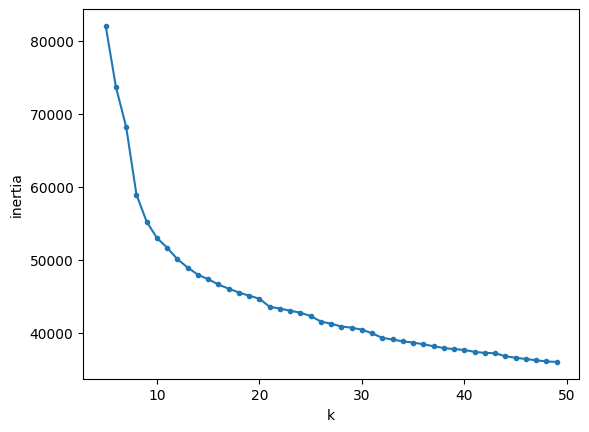

In [36]:
# find the best k for K-Means alg
from sklearn.cluster import KMeans
inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

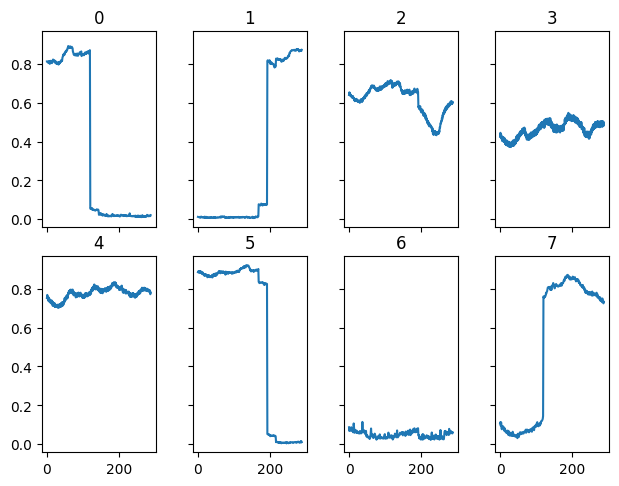

In [37]:
# try k=8
km8 = KMeans(n_clusters=8, random_state=42)
km8.fit(scaled_data)
# draw cluster centers
row = 2
col = 4
fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
plt.tight_layout()
for i in range(row):
    for j in range(col):
        axs[i][j].plot(range(len(km8.cluster_centers_[col*i+j])), km8.cluster_centers_[col*i+j])
        axs[i][j].set_title(col*i+j)

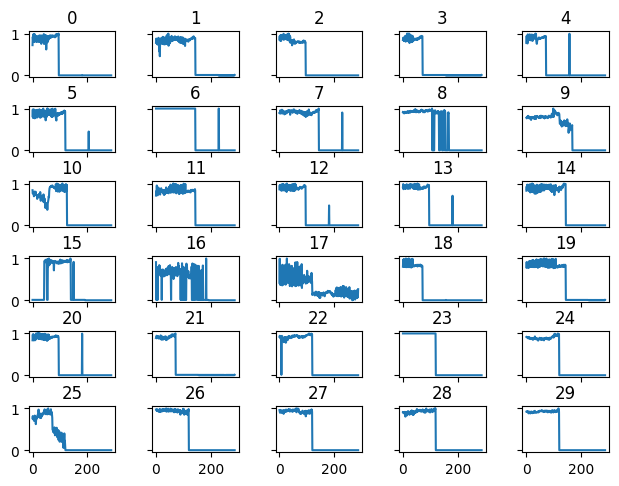

In [39]:
draw_pattern(scaled_data[km8.labels_==0][:30])

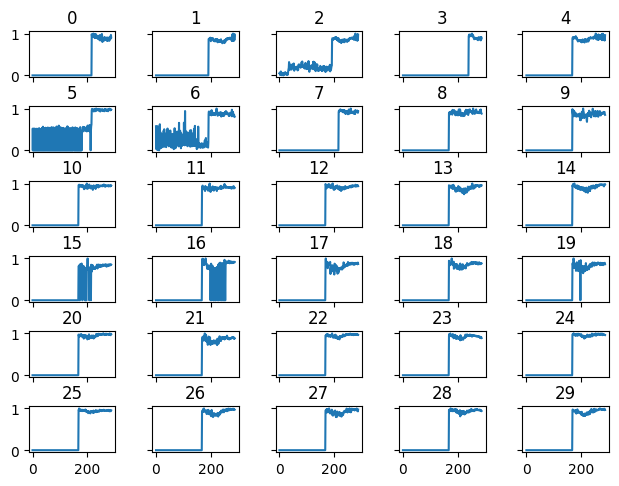

In [40]:
draw_pattern(scaled_data[km8.labels_==1][:30])

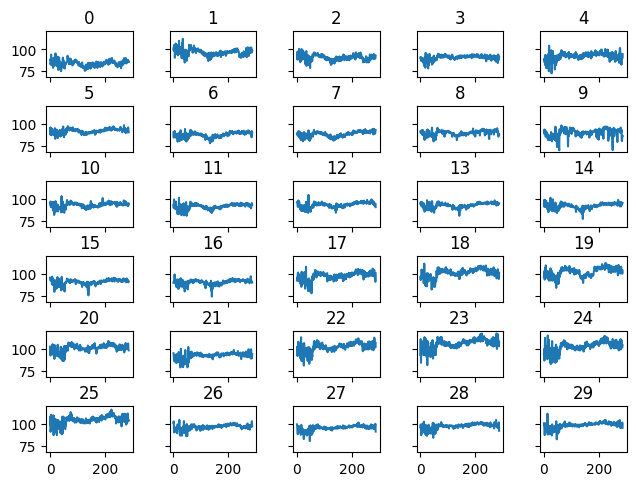

In [42]:
draw_pattern(data[:30])

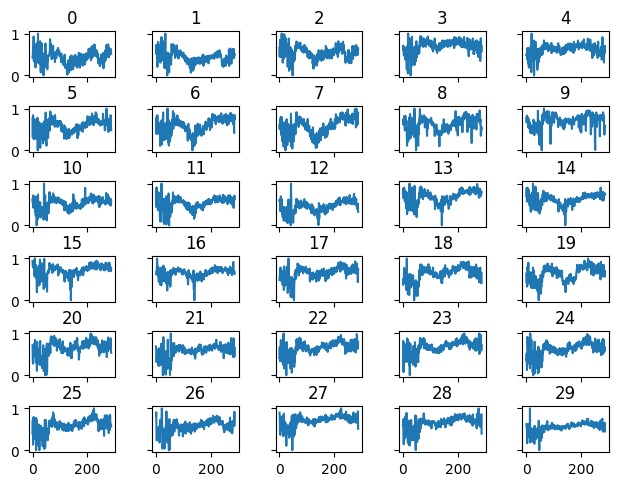

In [43]:
draw_pattern(scaled_data[:30])

In [44]:
# the minmax standardization seems inappropriate; it rather exacerbates the mess. exclude outliers first.
import gc
del scaled_data
del inertia
del km8
gc.collect()

69605